# Advanced Machine Learning - Project 1
## Caenorhabditis elegans roundworms exploration

- Eduardo Carneiro - 62515
- Til Dietrich - 62928


## Todo List
- Classification (KNN with different metrics, Different data representations like PAA and SAX into KNN, Summarization methods into KNN, etc) (maybe search for other classifiers other than KNN for time series)
- 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.metrics import accuracy_score, f1_score
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

from scipy.stats import mode

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [3]:
df_train = pd.read_csv("../worms_trainset.csv")
y_train = df_train.iloc[:,0]
df_train.drop(columns=[ df_train.columns[0] ], inplace=True)

df_test = pd.read_csv("../worms_testset.csv")
y_test = df_test.iloc[:,0]
df_test.drop(columns=[ df_test.columns[0] ], inplace=True)

NaN Count: 0
(180, 900)
(76, 900)


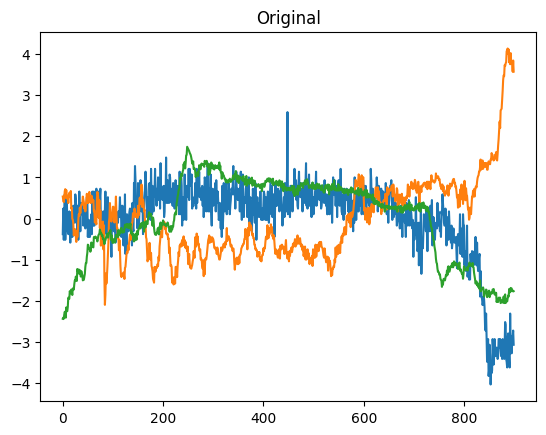

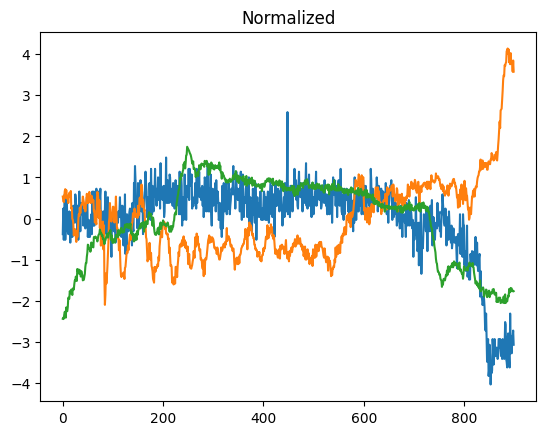

In [4]:
print(f'NaN Count: {df_train.isnull().sum().sum()}') # How many NaNs are there?

# WE DO NOT NEED TO NORMALIZE THE DATA!!!! ALREADY NORMALIZED!!! (it could be seen from the plots, but this was just to be sure)
print( df_train.shape)
print( df_test.shape)

n = 3

for i in range(n):
    plt.plot( range(0,900),df_train.iloc[i,:])
plt.title("Original"	)
plt.show()

from tslearn.preprocessing import TimeSeriesScalerMeanVariance

X_train_normalized = TimeSeriesScalerMeanVariance().fit_transform(df_train.iloc[:n,:]).reshape(n,-1)

for i in range(n):
    plt.plot( range(0,900),X_train_normalized[i,:])
plt.title("Normalized")
plt.show()


# Noise Removal
## Questions
- Is there noise that we should remove?
- If yes, should we use moving average?
    - If yes, what window size should we use?
- SHOULD WE DO MOVING AVERAGE ON THE TEST SET TOO???!?!?!?!?!?!?!?

In [5]:
# Moving-Average Smoothing
n = 900
window_size = 5

df_train_mov_avg = np.array([df_train.iloc[i,:].rolling(window_size).mean() for i in range( df_train.iloc[:n,:].shape[0] )])[:,window_size:]
df_test_mov_avg = np.array([df_test.iloc[i,:].rolling(window_size).mean() for i in range( df_test.iloc[:n,:].shape[0] )])[:,window_size:]

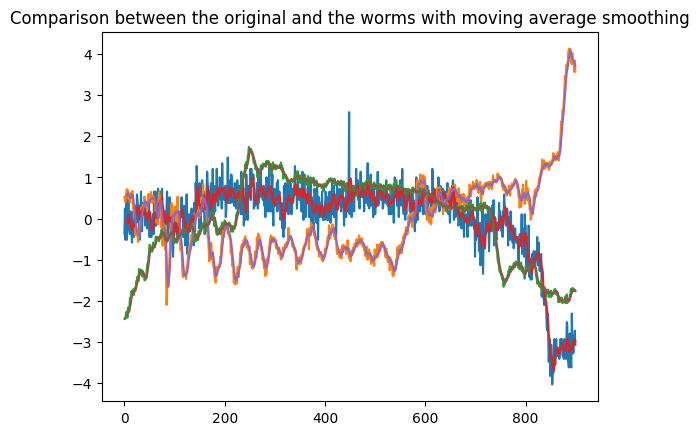

In [4]:
n_plot = 3

plt.title("Comparison between the original and the worms with moving average smoothing")
for i in range(n_plot):
    plt.plot( range(0,900),df_train.iloc[i,:])

for i in range(n_plot):
    plt.plot( range(window_size,900),df_train_mov_avg[i] )
plt.show()


# Representation
- Should we change the original representation for another one?
    - If yes, which one should we use? (maybe DFT makes sense here, since the worms behave like waves???? idk)

### PAA

In [6]:
n_seg = 550
paa = PiecewiseAggregateApproximation(n_segments= n_seg)

df_train_paa = paa.fit_transform( df_train_mov_avg ).reshape(180,n_seg)
# df_train_paa = pd.DataFrame(df_train_paa).dropna(axis=1)

df_test_paa = paa.fit_transform( df_test_mov_avg ).reshape(76,n_seg)
# df_test_paa = pd.DataFrame(df_test_paa).dropna(axis=1)

d:\OneDrive - Universidade de Coimbra\Mestrado\Files\1Semestre\AAA\P\P1\venv_AML\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 180 1-dimensional timeseries
  warnings.warn(
d:\OneDrive - Universidade de Coimbra\Mestrado\Files\1Semestre\AAA\P\P1\venv_AML\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 76 1-dimensional timeseries
  warnings.warn(


### Summarization Methods
- This is a really basic summarization method, but it might be useful to reduce the size of the dataset
- We can further extend the summarization method to include more features, like other statistical measures

In [7]:
ft_space_train = [ [np.mean(i), np.median(i), mode(i).mode, np.var(i)] for i in df_train_mov_avg ]
ft_space_test = [ [np.mean(i), np.median(i), mode(i).mode, np.var(i)] for i in df_test_mov_avg ]

### DFT

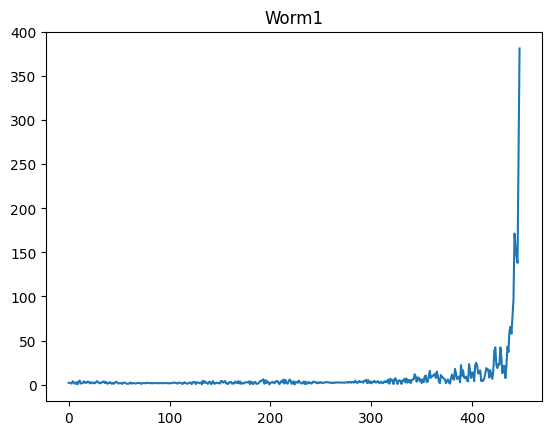

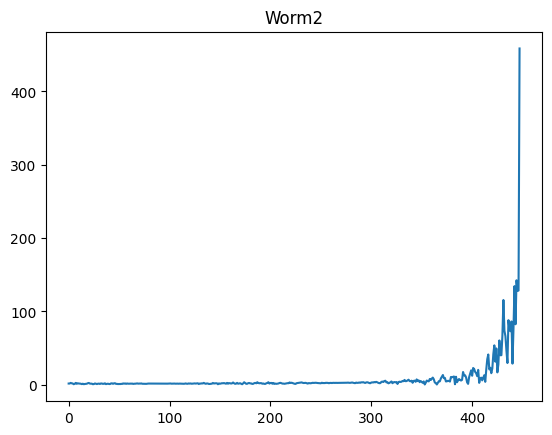

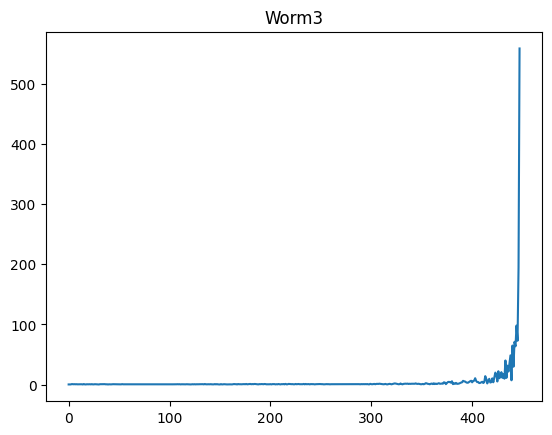

In [8]:
dfts_train = np.fft.fft(df_train_mov_avg)
dfts_test = np.fft.fft(df_test_mov_avg)

# Why this? Because the DFT returns complex values and KNN does not support complex values
# We convert a complex value into a tuple with the real and imaginary part as floats
dfts_train_fin = []
for worm in dfts_train:
    temp = []
    for complex_val in worm:
        temp.append([complex_val.real, complex_val.imag])
    dfts_train_fin.append(temp)

dfts_test_fin = []
for worm in dfts_test:
    temp = []
    for complex_val in worm:
        temp.append([complex_val.real, complex_val.imag])
    dfts_test_fin.append(temp)


half = int(len(dfts_train[0])/2)

# plot the dft
plt.title("Worm1")
plt.plot(abs(dfts_train[0][half:]))
plt.show()

# plot the dft
plt.title("Worm2")
plt.plot(abs(dfts_train[1][half:]))
plt.show()

# plot the dft
plt.title("Worm3")
plt.plot(abs(dfts_train[2][half:]))
plt.show()

# Classification
- Should we use other classifiers? KNN was the one shown in classes, we might have to search for another classifiers for time series data


- Just some tests to see how the KNN performs on the original raw data with some metrics


In [136]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(df_train, y_train)

        y_pred = knn.predict(df_test)
        print(f"{metric}:knn{neigh_num}|{accuracy_score(y_test, y_pred)}")

euclidean:knn1|0.6052631578947368
euclidean:knn3|0.5394736842105263
euclidean:knn5|0.5
euclidean:knn7|0.5131578947368421
euclidean:knn9|0.5526315789473685
dtw:knn1|0.618421052631579
dtw:knn3|0.5526315789473685
dtw:knn5|0.5394736842105263
dtw:knn7|0.5657894736842105
dtw:knn9|0.5921052631578947


- Observing KNN performance with smoothed data from moving average

In [137]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(df_train_mov_avg, y_train)

        y_pred = knn.predict(df_test_mov_avg)
        print(f"{metric}:knn{neigh_num}|{accuracy_score(y_test, y_pred)}")

euclidean:knn1|0.5789473684210527
euclidean:knn3|0.5263157894736842
euclidean:knn5|0.4868421052631579
euclidean:knn7|0.5131578947368421
euclidean:knn9|0.5394736842105263
dtw:knn1|0.618421052631579
dtw:knn3|0.618421052631579
dtw:knn5|0.5789473684210527
dtw:knn7|0.5526315789473685
dtw:knn9|0.618421052631579


- Observing KNN performance with PAA representation

In [138]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn_paa = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)
        knn_paa.fit( df_train_paa, y_train)

        y_pred = knn_paa.predict(df_test_paa)
        # Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). 
        # This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
        print(f"PAA|{metric}:knn{neigh_num}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")



PAA|euclidean:knn1|acc:0.6578947368421053|f1:0.6561780796076211
PAA|euclidean:knn3|acc:0.631578947368421|f1:0.6206140350877193
PAA|euclidean:knn5|acc:0.6578947368421053|f1:0.6436726737478617
PAA|euclidean:knn7|acc:0.6710526315789473|f1:0.6551914377137814
PAA|euclidean:knn9|acc:0.6447368421052632|f1:0.6092465205567109
PAA|dtw:knn1|acc:0.618421052631579|f1:0.6191632928475034
PAA|dtw:knn3|acc:0.5526315789473685|f1:0.5542079299729239
PAA|dtw:knn5|acc:0.5789473684210527|f1:0.5768345595170722
PAA|dtw:knn7|acc:0.5657894736842105|f1:0.5590630485453656
PAA|dtw:knn9|acc:0.6052631578947368|f1:0.6032823995472553


- Observing KNN performance with SAX representation

In [139]:
for n_seg in [250, 350, 450, 550, 650]:
    for alph_size in [10, 20, 30, 40]:
        for neigh_num in [1,3,5]:
            knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= "sax", metric_params={"n_segments": n_seg, "alphabet_size_avg": alph_size})
            knn.fit(df_train, y_train)

            y_pred = knn.predict(df_test)
            print(f"SAX|knn{neigh_num}|n_seg:{n_seg}:alph_size:{alph_size}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

SAX|knn1|n_seg:250:alph_size:10|acc:0.6052631578947368|f1:0.6074745687748785
SAX|knn3|n_seg:250:alph_size:10|acc:0.5394736842105263|f1:0.5323395969420543
SAX|knn5|n_seg:250:alph_size:10|acc:0.5394736842105263|f1:0.5323395969420543
SAX|knn1|n_seg:250:alph_size:20|acc:0.5526315789473685|f1:0.5542079299729239
SAX|knn3|n_seg:250:alph_size:20|acc:0.5131578947368421|f1:0.5141048908744008
SAX|knn5|n_seg:250:alph_size:20|acc:0.5657894736842105|f1:0.5622694820278945
SAX|knn1|n_seg:250:alph_size:30|acc:0.5526315789473685|f1:0.5542079299729239
SAX|knn3|n_seg:250:alph_size:30|acc:0.5394736842105263|f1:0.5384059399434916
SAX|knn5|n_seg:250:alph_size:30|acc:0.5657894736842105|f1:0.5622694820278945
SAX|knn1|n_seg:250:alph_size:40|acc:0.5526315789473685|f1:0.5542079299729239
SAX|knn3|n_seg:250:alph_size:40|acc:0.5263157894736842|f1:0.5208237986270023
SAX|knn5|n_seg:250:alph_size:40|acc:0.5657894736842105|f1:0.5622694820278945
SAX|knn1|n_seg:350:alph_size:10|acc:0.6052631578947368|f1:0.6066540558584622

- Observing KNN performance with summarization methods representation

In [140]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(ft_space_train, y_train)

        y_pred = knn.predict(ft_space_test)
        print(f"feature_space|{metric}:knn{neigh_num}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

feature_space|euclidean:knn1|acc:0.5657894736842105|f1:0.5504069451980467
feature_space|euclidean:knn3|acc:0.5394736842105263|f1:0.5323395969420543
feature_space|euclidean:knn5|acc:0.5921052631578947|f1:0.5887986043292341
feature_space|euclidean:knn7|acc:0.5263157894736842|f1:0.5208237986270023
feature_space|euclidean:knn9|acc:0.5526315789473685|f1:0.5393170426065164
feature_space|dtw:knn1|acc:0.5394736842105263|f1:0.5172680127992938
feature_space|dtw:knn3|acc:0.5657894736842105|f1:0.5551246537396122
feature_space|dtw:knn5|acc:0.5921052631578947|f1:0.5857865001486767
feature_space|dtw:knn7|acc:0.5131578947368421|f1:0.5056161453387432
feature_space|dtw:knn9|acc:0.5526315789473685|f1:0.5393170426065164


- Observing KNN performance with DFT representation

In [141]:
for metric in ["euclidean", "dtw"]:
    for neigh_num in [1,3,5,7,9]:

        knn = KNeighborsTimeSeriesClassifier(n_neighbors= neigh_num, metric= metric)

        knn.fit(dfts_train_fin, y_train)

        y_pred = knn.predict(dfts_test_fin)
        print(f"DFT|{metric}:knn{neigh_num}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

DFT|euclidean:knn1|acc:0.5789473684210527|f1:0.5789473684210527
DFT|euclidean:knn3|acc:0.5263157894736842|f1:0.5169324632196779
DFT|euclidean:knn5|acc:0.4868421052631579|f1:0.48565233307989075
DFT|euclidean:knn7|acc:0.5131578947368421|f1:0.5012003693444137
DFT|euclidean:knn9|acc:0.5394736842105263|f1:0.5172680127992938
DFT|dtw:knn1|acc:0.5394736842105263|f1:0.5231588812706556
DFT|dtw:knn3|acc:0.5789473684210527|f1:0.5706066339730471
DFT|dtw:knn5|acc:0.631578947368421|f1:0.6242808047264162
DFT|dtw:knn7|acc:0.6447368421052632|f1:0.6392334033552991
DFT|dtw:knn9|acc:0.6578947368421053|f1:0.6477130325814535


## Random Forest

In [22]:

# print(np.reshape(dfts_train_fin, (180,895*2))[0,:4])
print(np.reshape(dfts_test_fin, (76,895*2)).shape)

(76, 1790)


In [24]:
for tree_num in [100, 200, 250, 300]:
    for rep_train, rep_test,name in zip([df_train_mov_avg, df_train_paa, ft_space_train, dfts_train_fin], [df_test_mov_avg, df_test_paa, ft_space_test, dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
        rfc = RandomForestClassifier(n_estimators=tree_num)

        if name == "dft":
            rep_train = np.reshape(rep_train, (180,895*2))
            rep_test = np.reshape(rep_test, (76,895*2))

        rfc.fit(rep_train, y_train)
        y_pred = rfc.predict(rep_test)

        print(f"RFC|tree_num:{tree_num}|{name}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

RFC|tree_num:100|mov_avg|acc:0.6578947368421053|f1:0.6511178901031008
RFC|tree_num:100|paa|acc:0.631578947368421|f1:0.631578947368421
RFC|tree_num:100|ft_space|acc:0.6578947368421053|f1:0.6578947368421053
RFC|tree_num:100|dft|acc:0.618421052631579|f1:0.6202301187560648
RFC|tree_num:200|mov_avg|acc:0.6842105263157895|f1:0.6826259196378042
RFC|tree_num:200|paa|acc:0.5921052631578947|f1:0.5911595468070927
RFC|tree_num:200|ft_space|acc:0.6973684210526315|f1:0.694915093534593
RFC|tree_num:200|dft|acc:0.618421052631579|f1:0.612509951751988
RFC|tree_num:250|mov_avg|acc:0.6578947368421053|f1:0.6539282990083906
RFC|tree_num:250|paa|acc:0.6052631578947368|f1:0.6052631578947368
RFC|tree_num:250|ft_space|acc:0.6578947368421053|f1:0.6561780796076211
RFC|tree_num:250|dft|acc:0.6052631578947368|f1:0.6032823995472553
RFC|tree_num:300|mov_avg|acc:0.631578947368421|f1:0.6206140350877193
RFC|tree_num:300|paa|acc:0.631578947368421|f1:0.6297302395774382
RFC|tree_num:300|ft_space|acc:0.6578947368421053|f1:0

## Logistic regression classifier

In [20]:
for rep_train, rep_test,name in zip([df_train_mov_avg, df_train_paa, ft_space_train, dfts_train_fin], [df_test_mov_avg, df_test_paa, ft_space_test, dfts_test_fin] ,["mov_avg", "paa", "ft_space", "dft"]):
    lrc = LogisticRegression(random_state=0, max_iter=2200)

    if name == "dft":
        rep_train = np.reshape(rep_train, (180,895*2))
        rep_test = np.reshape(rep_test, (76,895*2))

    lrc.fit(rep_train, y_train)
    y_pred = lrc.predict(rep_test)

    print(f"LRC|{name}|acc:{accuracy_score(y_test, y_pred)}|f1:{f1_score(y_test, y_pred, average='weighted')}")

LRC|mov_avg|acc:0.5131578947368421|f1:0.5161331826160477
LRC|paa|acc:0.5131578947368421|f1:0.5154660135853241
LRC|ft_space|acc:0.5921052631578947|f1:0.4536474877032152
LRC|dft|acc:0.5921052631578947|f1:0.5945980719215535


## HMM ???